In [1]:
library(ggplot2)
library(dplyr)
library(reshape2)
library(binom)
library(tidyverse)
library(ggbreak)
library(ggVennDiagram)
library(ggvenn)
library(patchwork)
library(scales)
library(data.table)
library(ggpubr)
library(arrow)
library(readxl)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846


Loading requir

In [80]:
pl_theme = theme(plot.title = element_text(size = 10, face = "bold"), 
          axis.text=element_text(size=6),
          axis.title=element_text(size=8),
          legend.text = element_text(size=6),
          legend.title = element_text(size=7),
          strip.text = element_text(size=6),
          axis.ticks = element_line(colour = "black", linewidth = 0.4),
          legend.key.size = unit(4, 'mm'),
          text = element_text(family='Arial'),
          panel.background = element_blank(),
          axis.line = element_line(colour = "grey"),
          legend.key = element_rect(colour = NA, fill = NA)
         ) 
pl_theme_half_page = theme(plot.title = element_text(size = 6, face = "bold"), 
          axis.text=element_text(size=5),
          axis.title=element_text(size=6),
          legend.text = element_text(size=3),
          legend.title = element_text(size=4.5),
          strip.text = element_text(size=5),
          axis.ticks = element_line(colour = "black", linewidth = 0.2),
          legend.key.size = unit(2, 'mm'),
          text = element_text(family='Arial'),
          panel.background = element_blank(),
          axis.line = element_line(colour = "grey"),
          legend.key = element_rect(colour = NA, fill = NA)
         ) 
simple_annot_names = c('non-genic', 'putative regulatory', 'coding')

In [81]:
annot_colors <- c(
    "LoF" = "#DE3F2E",
    "missense" = "#FDD384",
    "synonymous" = "#E5E5AB",
    "UTR3" = "#807DBA",
    "UTR5" = "#BCBDDC",
    "promoter" = "#08519C",
    "CRE" = "#4292C6",
    "conserved" = "grey",
    "non-genic" = "#C6DBEF"
)
simple_annot_colors <- c(
    "coding" = "#FDD384",
    "putative regulatory" = "#08519C",
    "non-genic" = "#C6DBEF"
)
method_colors <- c(
    "SuSiE" = "#4169e1",
    "SuSiE-inf" = "#91dce3",
    "FINEMAP" = "#FFA500",
    "FINEMAP-inf" = "#673147",
    "ABF" = "#32CD32",
    "COJO-ABF" = "#cb98fb",
    "minPIP" = "#708090",
    "minPIP-inf" = "#ffb6c1")

pheno_colors <- c(
    "LDLC" = '#083647',
    "ALP" = '#5E4FA2',
    "HbA1c" = '#3F96B7',
    "Lym" = '#88CFA4',
    "Plt" = '#D7EF9B',
    "RBC" = 'yellow',
    "eGFR" = '#FDD380',
    "IGF1" = '#F88D51',
    "eBMD" = '#DC494C',
    "Height" = '#9E0142'
)
method_shapes <- c(
    "SuSiE" = 8,
    "SuSiE-inf" = 19,
    "FINEMAP" = 7,
    "FINEMAP-inf" = 15,
    "minPIP" = 9,
    "minPIP-inf" = 17
)

sim_colors <- c(
    "Ideal" = "#a0ddff",
    "Baseline misspecification" = "#758ecd",
    "Moderate stratification w/ BOLT" = "#ec9192",
    "Moderate non-sparsity" = "#729ea1",
    "High non-sparsity" = "#b5bd89",
    "Very high non-sparsity" = "#dfbe99",
    "No large effects" = "#ebbb5c",
    "Severe stratification w/ BOLT"="#8CBFAF",
    "Moderate stratification w/ OLS"="#023778",
    "Severe stratification w/ OLS"="#4281A4",
    "1% coverage, ratio=3:1"= "#b5bd89",
    "0.5% coverage, ratio=3:1"='#4FC47E',
    "5% coverage, ratio=3:1"='#D05B5B',
    "5% coverage, ratio=15:1"='#F2CD5D'
)

In [82]:
path_pref = ''

# Fig. 1 RFR and functional enrichments

In [83]:
# Aggregated RFR plot
all_rfr = read_excel("Supplementary Tables.xlsx", sheet = 4)
all_rfr[all_rfr=='Simulation'] = 'Ideal simulation'
all_rfr$segment_legend='EPN'
# Compute Binomial proportion SD
all_rfr$std = sqrt((all_rfr$rfr)*(all_rfr$n_highpip)*(1-all_rfr$rfr))/all_rfr$n_highpip
# Filter to aggregated RFR
selected_method_names = c('SuSiE','FINEMAP')
data_to_plot = all_rfr %>% filter(trait=='agg') %>% filter(method_name %in% selected_method_names)
data_to_plot$method_name <- factor(data_to_plot$method_name, levels = selected_method_names)
# Compute EPN line segment positions
num_methods = length(selected_method_names)
barwidth = 0.85/num_methods
pos_dodge = 1
xstart = c(seq(1-barwidth*num_methods/2,1+barwidth*num_methods/2-barwidth,length.out=num_methods),
  seq(1-barwidth*num_methods/2+pos_dodge, 1+barwidth*num_methods/2-barwidth+pos_dodge, length.out=num_methods))
xend = c(seq(1-barwidth*num_methods/2+barwidth,1+barwidth*num_methods/2,length.out=num_methods),
  seq(1-barwidth*num_methods/2+barwidth+pos_dodge,1+barwidth*num_methods/2+pos_dodge,length.out=num_methods))
# Plot
pl_rfr = ggplot(data=data_to_plot, aes(x=data.type, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85, size=0.35) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=0.4,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2,linewidth=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(axis.title.x = element_blank(),
                     legend.title = element_blank())

New names:
• `` -> `...1`


In [84]:
# Trait separated RFR plot
# Compute EPN line segment positions
pos_dodge = 0.85
num_traits = 10
traits_xstart = c(seq(1-barwidth*num_methods/2,1*num_traits+barwidth*num_methods/2-barwidth-barwidth,length.out=num_traits),
  seq(1-barwidth*num_methods/2+barwidth, 1*num_traits+barwidth*num_methods/2-barwidth+barwidth-barwidth, length.out=num_traits))
traits_xend = c(seq(1-barwidth*num_methods/2+barwidth,1*num_traits+barwidth*num_methods/2-barwidth,length.out=num_traits),
  seq(1-barwidth*num_methods/2+barwidth+barwidth,1*num_traits+barwidth*num_methods/2+barwidth-barwidth,length.out=num_traits))
# Filter to trait only RFR results
traits_data_to_plot <- all_rfr %>% filter(method_name %in% selected_method_names) %>% filter(trait != 'agg')
traits_data_to_plot$method_name <- factor(traits_data_to_plot$method_name, levels = selected_method_names)
# Plot
pl_trait_rfr = ggplot(data=traits_data_to_plot, 
       aes(x=forcats::fct_reorder(trait, rfr, .desc = TRUE), y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85, size=0.35) + 
    geom_segment(data=traits_data_to_plot, aes(x=traits_xstart, y=epn, 
                 xend=traits_xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=0.4,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2,linewidth=0.2)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(legend.title=element_blank(),
                     axis.title.x = element_blank())

In [85]:
# Aggregated functional enrichment plot for SuSiE + FINEMAP
func_enrich = read_excel("Supplementary Tables.xlsx", sheet = 5)
selected_methods = c('SuSiE','FINEMAP')
selected_groups = c('Non-replicating','Replicated','Background')
# Combine annotation groups
func_enrich_selected = (func_enrich %>% filter(method_name %in% selected_methods)
                            %>% filter(type %in% selected_groups)
                            %>% mutate(coding=(LoF + missense))
                            %>% mutate("putative regulatory"=(synonymous+UTR3+UTR5+promoter+CRE+conserved))
                            %>% dplyr::select(type, coding, "putative regulatory", "non-genic"))
# aggregate methods
agg_methods <- func_enrich_selected %>% group_by(type) %>% summarise(across(all_of(simple_annot_names), sum))
data <- as.data.frame(agg_methods)
melted_data <-  reshape2::melt(data , id.vars = c("type"), measure.vars = simple_annot_names)
data <- group_by(melted_data,type)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$type<-factor(data$type, levels= selected_groups)
data$variable <- factor(data$variable,levels=simple_annot_names)
# plot
pl_func_enrich <- qplot(x = type, y = prop, fill = variable, data = data, geom = "col") +
    geom_errorbar(aes(x=type,ymin=1-prop+std,ymax=1-prop-std),width=.1, linewidth=0.3, 
              data=data %>% filter(variable=='non-genic'),
              inherit.aes = FALSE)+
    ylab('Proportion')+
    scale_fill_manual(values = simple_annot_colors) +
    scale_x_discrete(labels=c("Non-replicating" = "Non-replicating\n n=116", "Replicated" = "Replicated\n n=703",
                              "Background" = "Background\n n=52M"))+
    pl_theme + theme(plot.title = element_text(hjust=0.4),
                     axis.title.y=element_blank()) + 
    coord_flip() +guides(fill=guide_legend(title="Categories")) 

New names:
• `` -> `...1`


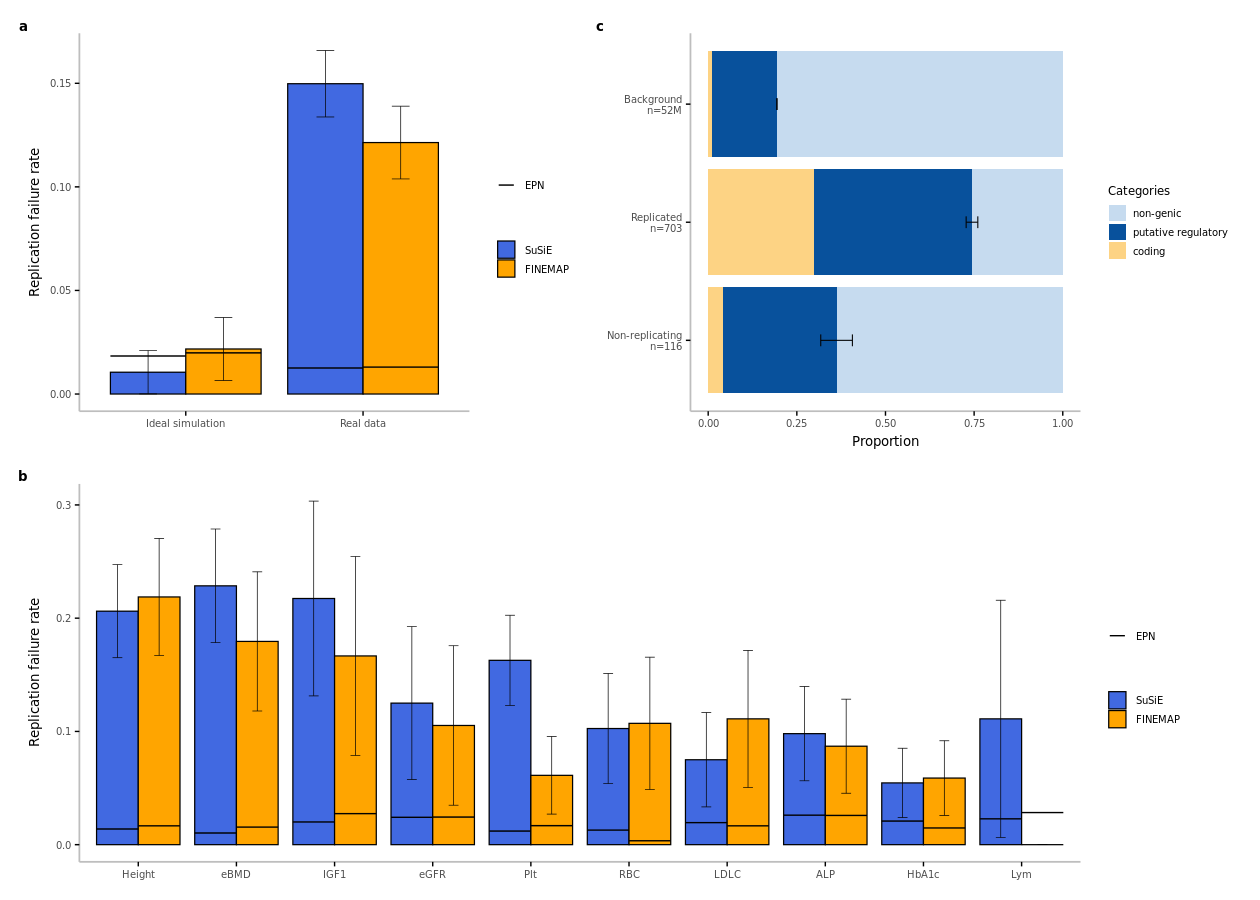

In [86]:
options(repr.plot.width=10.5, repr.plot.height=7.5)
layout <- "
AC
BB
"
fig1 <- pl_rfr + pl_trait_rfr + pl_func_enrich + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=8),
                                           legend.justification = "left")
fig1

In [87]:
cowplot::save_plot(
  paste0(path_pref, "/Fig1_RFR.pdf"),
  fig1,
  base_height = 128,
  base_width = 180,
  device = cairo_pdf,
  units = 'mm',
  dpi=600
)

# Fig. 2 Main calibration plot

In [88]:
calib_df = read_excel("Supplementary Tables.xlsx", sheet = 6)
selected_sims = c('Baseline misspecification',
                  'Moderate non-sparsity','High non-sparsity','Very high non-sparsity','No large effects')
selected_methods = c('SuSiE','SuSiE-inf','FINEMAP','FINEMAP-inf','minPIP','minPIP-inf')
calib_to_plot <- calib_df %>% filter(sim_name %in% selected_sims)
calib_to_plot$sim_name = factor(calib_to_plot$sim_name, selected_sims)
calib_to_plot$method_name = factor(calib_to_plot$method_name, selected_methods)
calib_to_plot[,c('mean','lower','upper')] = binom.confint(calib_to_plot$num_causal,calib_to_plot$num_snps, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
calib_to_plot$bin_name <- factor(calib_to_plot$bin_name, 
                                 levels=c('[0,0.01]','(0.1,0.5]','(0.5,0.9]','(0.9,1]'))
pl_calib <- ggplot(calib_to_plot, aes(bin_name, prop_causal)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color=sim_name, shape=method_name,
            group=interaction(method_category, sim_name),),
        position = position_dodge(1),
        size=0.4, linewidth=0.1, stroke=0.25)+
    #geom_hpline(aes(bin_name, mean_pip, color= sim_name, linetype=EPC,
    #                group=interaction(method_category, sim_name)), 
    #            position=position_dodge(1), size = 1, 
    #            width = 0.08,inherit.aes = FALSE, color='black')+
    geom_point(aes(bin_name, mean_pip, shape=EPC,
                   group=interaction(method_category, sim_name)), position=position_dodge(1),
               color="Black", size=2, stroke=0.5, shape=95) +
    ylab('Proportion causal')+
    xlab("PIP bins") + pl_theme + 
    theme(strip.background = element_blank(),
          strip.text.y = element_blank(),
          panel.background = element_rect(fill = 'white', color = 'grey'))+
    scale_shape_manual(values=c(method_shapes)) +
    scale_color_manual(values=sim_colors[selected_sims]) +
    scale_fill_manual(values=sim_colors[selected_sims]) +
    guides(color=guide_legend(title="Simulation type"),
           fill=guide_legend(title="Simulation type"),
           shape=guide_legend(title="Method"),
           group=guide_legend(title=" "))

New names:
• `` -> `...1`


In [89]:
recall_df = read_excel("Supplementary Tables.xlsx", sheet = 7)
recall_to_plot <- recall_df %>% filter(sim_name %in% selected_sims) 
recall_to_plot$sim_name = factor(recall_to_plot$sim_name, selected_sims)
recall_to_plot$method_name = factor(recall_to_plot$method_name, selected_methods)
recall_to_plot[,c('mean','lower','upper')] = binom.confint(recall_to_plot$n_true_pos,recall_to_plot$tot_causal, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
pl_recall <- ggplot(recall_to_plot, aes(factor(top_n), recall)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper,color=sim_name, shape=method_name,
            group=interaction(method_category, sim_name)), 
        position = position_dodge(1),
        size=0.4, linewidth=0.1, stroke=0.25)+
    ylab('Recall')+
    xlab("Top N variants") + pl_theme + 
    theme(legend.position='none',
          strip.background = element_blank(),
          strip.text.y = element_blank(),
          panel.background = element_rect(fill = 'white', color = 'grey'))+
    scale_shape_manual(values=method_shapes) +
    scale_fill_manual(values=sim_colors[selected_sims]) +
    scale_color_manual(values=sim_colors)

New names:
• `` -> `...1`


In [106]:
regression_df = read_excel("Supplementary Tables.xlsx", sheet = 8)
regression_df$component_name = factor(regression_df$component_name,
                                      levels = c("Large sparse effects",
                                                 "Non-missing\nnon-sparse effects",
                                                 "Missing\nnon-sparse effects",
                                                 "Stratification effect"))
pl_regression <- ggplot(regression_df, aes(x=1, y=fstats)) +
    facet_wrap(.~component_name, scales="free",nrow=1) +
    geom_violin(aes(fill=causal_status), size=0.3) +
    ylab('Regression F statistics') +
    pl_theme +
    theme(
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          strip.background = element_blank()) +
    scale_x_continuous(name ="Causal status") +
    guides(fill=guide_legend(title="Causal status")) 

New names:
• `` -> `...1`


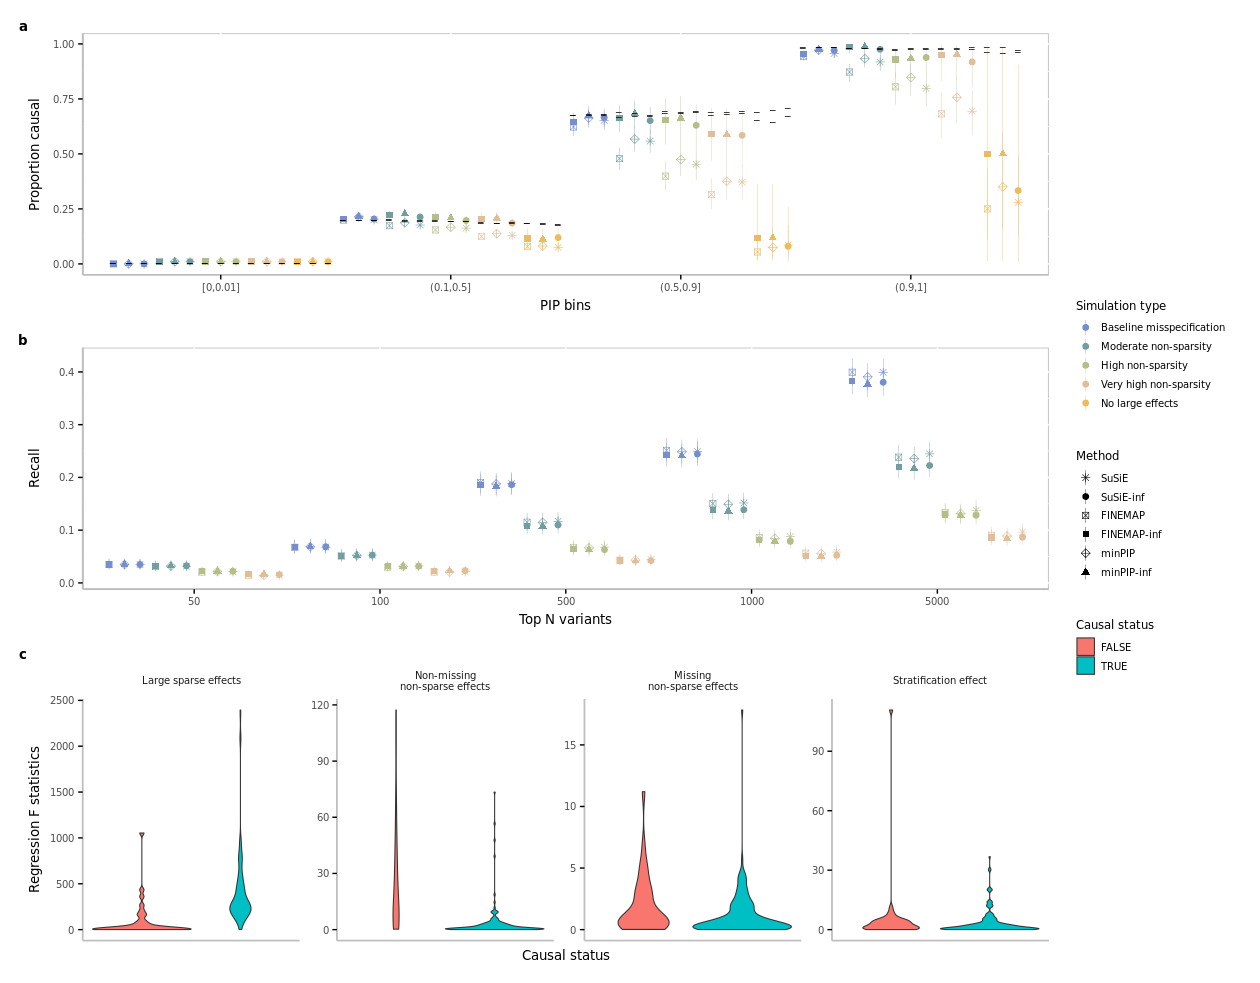

In [107]:
options(repr.plot.width=10.5, repr.plot.height=8.2)
layout <- "
A
B
C
"
fig2 <- pl_calib + pl_recall + pl_regression +plot_layout(design=layout,guides='collect')+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=8))
fig2

In [108]:
cowplot::save_plot(
  paste0(path_pref, "/Fig2_calib_nonsparsity.pdf"),
  fig2,
  base_height = 140,
  base_width = 180,
  device = cairo_pdf,
  units = 'mm',
  dpi = 600
)

# Fig. 3 Calibration plot -- strafitication

In [119]:
unique(calib_df$sim_name)

[1] "No large effects"                "Moderate non-sparsity"          
 [3] "High non-sparsity"               "Very high non-sparsity"         
 [5] "Baseline misspecification"       "Moderate stratification w/ OLS" 
 [7] "Severe stratification w/ OLS"    "Moderate stratification w/ BOLT"
 [9] "Severe stratification w/ BOLT"   "Ideal"

In [120]:
selected_sims = c('Moderate stratification w/ BOLT',
                  'Severe stratification w/ BOLT',
                  'Moderate stratification w/ OLS',
                  'Severe stratification w/ OLS')
calib_to_plot <- calib_df %>% filter(sim_name %in% selected_sims)
calib_to_plot$sim_name = factor(calib_to_plot$sim_name, selected_sims)
calib_to_plot$method_name = factor(calib_to_plot$method_name, selected_methods)
calib_to_plot[,c('mean','lower','upper')] = binom.confint(calib_to_plot$num_causal,calib_to_plot$num_snps, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
calib_to_plot$bin_name <- factor(calib_to_plot$bin_name, 
                                 levels=c('[0,0.01]','(0.1,0.5]','(0.5,0.9]','(0.9,1]'))
pl_calib <- ggplot(calib_to_plot, aes(bin_name, prop_causal)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = sim_name, shape=method_name,
            group=interaction(method_category, sim_name)),
        position = position_dodge(1),
        size=0.17, linewidth=0.1, stroke=0.15)+
    geom_point(aes(bin_name, mean_pip, shape=EPC,
                   group=interaction(method_category, sim_name)), position=position_dodge(1),
               color="Black", size=2, stroke=0.5, shape=95) +
    #geom_hpline(aes(bin_name, mean_pip, color= sim_name, linetype=EPC,
    #                group=interaction(method_category, sim_name)), 
    #            position=position_dodge(1), size = 1, 
    #            width = 0.08,inherit.aes = FALSE, color='black')+
    ylab('Proportion causal')+
    xlab("PIP bins") + pl_theme_half_page + 
    theme(strip.background = element_blank(),
          strip.text.y = element_blank(),
          panel.background = element_rect(fill = 'white', color = 'grey'),
          legend.position="bottom")+
    scale_shape_manual(values=method_shapes) +
    scale_color_manual(values=sim_colors[selected_sims]) +
    guides(color=guide_legend(title=" ",
                              nrow=2,byrow=TRUE),
           shape=guide_legend(title=" ",nrow=2,byrow=TRUE),
           group=guide_legend(title=" ")) 

In [121]:
recall_to_plot <- recall_df %>% filter(sim_name %in% selected_sims) 
recall_to_plot$sim_name = factor(recall_to_plot$sim_name, selected_sims)
recall_to_plot$method_name = factor(recall_to_plot$method_name, selected_methods)
recall_to_plot[,c('mean','lower','upper')] = binom.confint(recall_to_plot$n_true_pos,recall_to_plot$tot_causal, 
                                                   conf.level=0.95, methods='exact')[,c('mean','lower','upper')]
pl_recall <- ggplot(recall_to_plot, aes(factor(top_n), recall)) +
    geom_pointrange(
        aes(ymin = lower, ymax = upper, color = sim_name, shape=method_name,
            group=interaction(method_category, sim_name)),
        position = position_dodge(1),
        size=0.17, linewidth=0.1, stroke=0.15)+
    ylab('Recall')+
    xlab("Top N variants") + pl_theme_half_page + 
    theme(legend.position='none',
          strip.background = element_blank(),
          strip.text.y = element_blank(),
          panel.background = element_rect(fill = 'white', color = 'grey'))+
    scale_shape_manual(values=method_shapes) +
    scale_color_manual(values=sim_colors)  + 
    guides(color=guide_legend(title=" ",
                              nrow=2,byrow=TRUE),
           shape=guide_legend(title=" ", nrow=2,byrow=TRUE),
           group=guide_legend(title=" ")) 

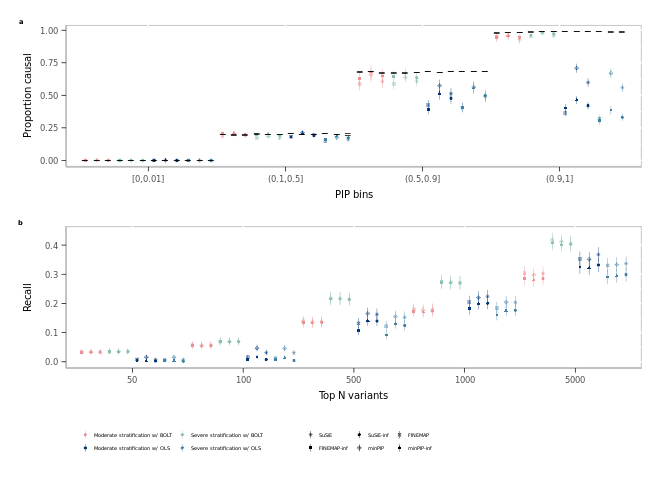

In [122]:
options(repr.plot.width=5.5, repr.plot.height=4)
layout <- "
A
B
"
fig3 <- pl_calib + pl_recall + plot_layout(design=layout,guides='collect')+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=4), 
                                           legend.position = "bottom",
                                           legend.justification = "left")
fig3

In [123]:
cowplot::save_plot(
  paste0(path_pref, "/Fig3_calib_strat.pdf"),
  fig3,
  base_height = 88,
  base_width = 88,
  device = cairo_pdf,
  unit='mm',
  dpi=600
)

# Fig. 4 Runtime

In [124]:
runtime.df = read_excel("Supplementary Tables.xlsx", sheet = 9)
# Distribution of region size in terms of number of SNPs
num_snps_pl = ggplot(runtime.df, aes(x=num_snps)) + 
 geom_histogram(aes(y=..density..), colour="black", fill="white", linewidth=0.1)+
 geom_density(alpha=.2, fill="#FF6666", linewidth=0.1) +
 xlab('Number of SNPs') +
 pl_theme_half_page + theme(axis.ticks.y=element_blank(),
                            axis.text.y=element_blank())
# Runtime
num_snp_quantiles = quantile(runtime.df$num_snps, probs = seq(0, 1, 0.1))
plot.df = na.omit(reshape2::melt(runtime.df %>% select(num_snps, susie_time, 
                                     susieinf_time, susieinf_with_eigdecomp_time,
                                     finemap_time, finemapinf_time, 
                                     finemapinf_with_eigdecomp_time), id = 'num_snps'))
plot.df$interval = cut(plot.df$num_snps, num_snp_quantiles, ordered_result=TRUE)
plt.df = na.omit(plot.df %>% 
                 group_by(variable,interval) %>% 
                 summarise(median=median(value,na.rm=TRUE),
                           mean = mean(value,na.rm=TRUE),
                           mean_num_snps = as.integer(mean(num_snps,na.rm=TRUE))) %>%
                 mutate(type = ifelse(grepl('eigdecomp',variable),
                                      'Eigen-decomposition not provided', 
                                      'Eigen-decomposition provided'),
                        name = ifelse(grepl('susieinf',variable),'SuSiE-inf',
                                      ifelse(grepl('susie',variable),'SuSiE',
                                             ifelse(grepl('finemapinf',variable),'FINEMAP-inf','FINEMAP')))))
selected_method_names = c('SuSiE','SuSiE-inf','FINEMAP','FINEMAP-inf')
runtime_pl = ggplot(plt.df, aes(x=mean_num_snps, y=mean, color=name, color=type)) +
  geom_line(aes(linetype=type), linewidth=0.25)+
  geom_point(aes(color=name), size=1) +
  scale_linetype_manual(values=c("dashed", "solid")) +
  ylab('Runtime in seconds') +
  xlab('Number of SNPs in region') +
  pl_theme_half_page + theme(legend.title=element_blank(), legend.key.size = unit(3.5, 'mm')) +
  scale_color_manual(values=method_colors[selected_method_names]) +
  guides(color=guide_legend(title=" ",
                              nrow=2,byrow=TRUE),
         linetype=guide_legend(title=" ",
                              nrow=2,byrow=TRUE))

New names:
• `` -> `...1`
`summarise()` has grouped output by 'variable'. You can override using the
`.groups` argument.
Warning message:
“Duplicated aesthetics after name standardisation: colour”


Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


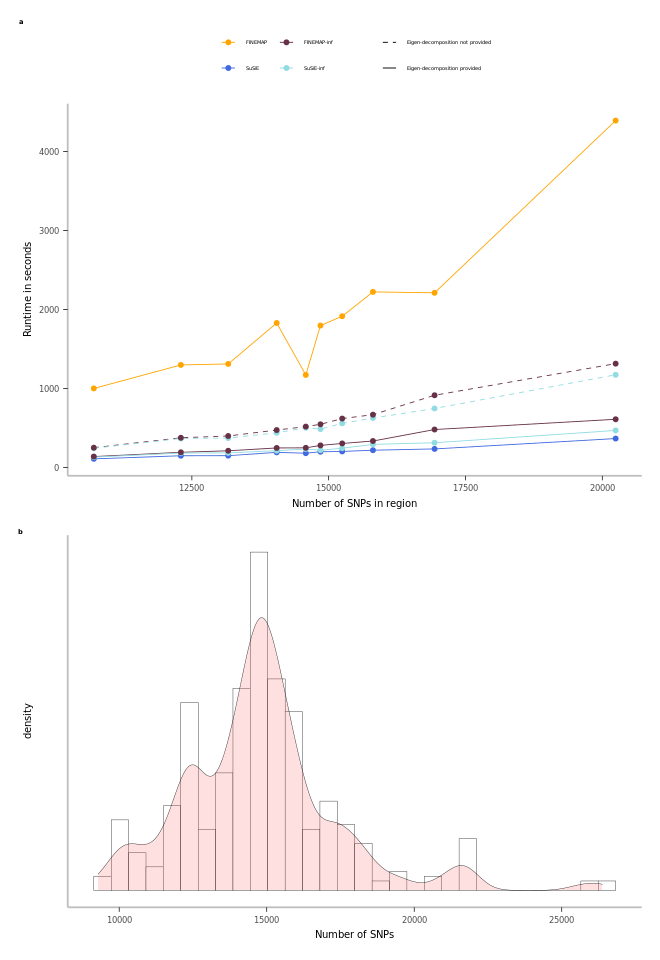

In [125]:
options(repr.plot.width=5.5, repr.plot.height=8)
layout <- "
A
B
"
fig4 <- runtime_pl + num_snps_pl + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=4),
                                           legend.position='top')
fig4

In [126]:
cowplot::save_plot(
  paste0(path_pref, "/Fig4_runtime.pdf"),
  fig4,
  base_height = 150,
  base_width = 88,
  device = cairo_pdf,
  unit = 'mm'
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


# Fig. 5 Real data improvement

In [127]:
# Aggregated RFR plot
rfr_df = read_excel("Supplementary Tables.xlsx", sheet = 4)
all_rfr = rfr_df %>% dplyr::select('trait','method_name','n_highpip','rfr','epn','data.type') %>%
    filter(data.type=='Real data')
all_rfr$segment_legend='EPN'
# Compute Binomial proportion SD
all_rfr$std = sqrt((all_rfr$rfr)*(all_rfr$n_highpip)*(1-all_rfr$rfr))/all_rfr$n_highpip
# Filter to aggregated RFR
selected_method_names = c('SuSiE','FINEMAP','SuSiE-inf','FINEMAP-inf')
data_to_plot = all_rfr %>% filter(trait=='agg') %>% filter(method_name %in% selected_method_names)
data_to_plot$method_name <- factor(data_to_plot$method_name, levels = selected_method_names)
# Compute EPN line segment positions
num_methods = length(selected_method_names)
barwidth = 0.85
pos_dodge = 1
xstart = seq(1-barwidth/2,num_methods-barwidth/2,length.out=num_methods)
xend = seq(1+barwidth/2,num_methods+barwidth/2,length.out=num_methods)
# Plot
pl_rfr = ggplot(data=data_to_plot, aes(x=method_name, y=rfr, fill=method_name)) +
    geom_bar(position=position_dodge(), color='black', stat="identity",width=0.85,size=0.35) + 
    geom_segment(data=data_to_plot, aes(x=xstart, y=epn, 
                 xend=xend, yend=epn, 
                 color=method_name,linetype=`segment_legend`), 
                 size=0.4,color='black',inherit.aes = FALSE)+
    geom_errorbar(aes(ymin=rfr-std, ymax=rfr+std),position=position_dodge(.85),width=0.2,linewidth=0.3)+
    ylab(label = "Replication failure rate")+
    scale_linetype_manual("EPN",values=c("EPN"=1))+
    scale_fill_manual(values=method_colors[selected_method_names])+
    pl_theme + theme(axis.title.x = element_blank(),
                     legend.title = element_blank(),
                     axis.text.x = element_blank(),
                     axis.ticks.x = element_blank())

New names:
• `` -> `...1`


In [128]:
set_diff_enrich = read_excel("Supplementary Tables.xlsx", sheet = 10)
selected = c('High-PIP for SuSiE \n and not SuSiE-inf',
                              'High-PIP for SuSiE-inf \n and not SuSiE',
                              'High-PIP for FINEMAP \n and not FINEMAP-inf',
                              'High-PIP for FINEMAP-inf \n and not FINEMAP')
set_diff_enrich = set_diff_enrich %>% filter(type_name %in% selected)
set_diff_enrich$type_name <-factor(set_diff_enrich$type_name, levels= selected)
melted_data <-  reshape2::melt(set_diff_enrich, id.vars = c("type_name"), measure.vars = simple_annot_names)
data <- group_by(melted_data,type_name)
data <- mutate(data, prop = value / sum(value), 
               std = sqrt(sum(value)*(value/sum(value))*(1-(value/sum(value))))/sum(value),
               sd_pos = cumsum(prop))
data$type_name<-factor(data$type_name, levels= selected)
data$variable <- factor(data$variable,levels=simple_annot_names)

pl_set_diff_enrich <- qplot(x = type_name, y = prop, fill = variable, data = data, geom = "col") +
    geom_errorbar(aes(x=type_name,ymin=1-prop+std,ymax=1-prop-std),width=0.1, linewidth=0.3, 
                  data=data %>% filter(variable=='non-genic'),
                  inherit.aes = FALSE)+
    pl_theme + theme(plot.title = element_text(hjust=0.4),
                     axis.title=element_blank(), legend.title= element_blank(),
                     legend.position='top') +
    scale_fill_manual(values = simple_annot_colors) + coord_flip()

New names:
• `` -> `...1`


In [155]:
all_data = read_excel('Supplementary Tables.xlsx', sheet=11)
point_size = 3
#SuSiE and SuSiE-inf
df.melt = (all_data %>% 
           filter(method_name %in% c('SuSiE','SuSiE-inf')) %>% 
           select(trait,method_name,delta_r2,cohort))
plot_df = dcast(setDT(df.melt), trait+cohort ~ method_name, value.var = "delta_r2")
colnames(plot_df) = make.names(colnames(plot_df))
p1 = ggplot(plot_df,
       aes(x=SuSiE,y=SuSiE.inf, color=trait, shape=cohort)) +
    geom_point(size=point_size, stroke=0.25)+
    geom_abline(slope=1, linewidth=0.25)+
    xlim(-0.001,NA)+ylim(-0.001,NA)+
    xlab('SuSiE')+ylab('SuSiE-inf')+scale_color_brewer(palette='Set1')+
    pl_theme
# FINEMAP and FINEMAPinf
df.melt = (all_data %>% 
           filter(method_name %in% c('FINEMAP','FINEMAP-inf')) %>% 
           select(trait,method_name,delta_r2,cohort))
plot_df = dcast(setDT(df.melt), trait+cohort ~ method_name, value.var = "delta_r2")
colnames(plot_df) = make.names(colnames(plot_df))
p2 = ggplot(plot_df,
       aes(x=FINEMAP,y=FINEMAP.inf, color=trait,shape=cohort)) +
    geom_point(size=point_size, stroke=0.25)+
    geom_abline(slope=1, linewidth=0.25)+
    xlim(-0.001,NA)+ylim(-0.001,NA)+
    xlab('FINEMAP')+ylab('FINEMAP-inf')+scale_color_brewer(palette='Set1')+
    pl_theme

pl_prs = p1 + p2  + plot_layout(ncol = 2, guides = "collect") & theme(legend.position='bottom')

New names:
• `` -> `...1`


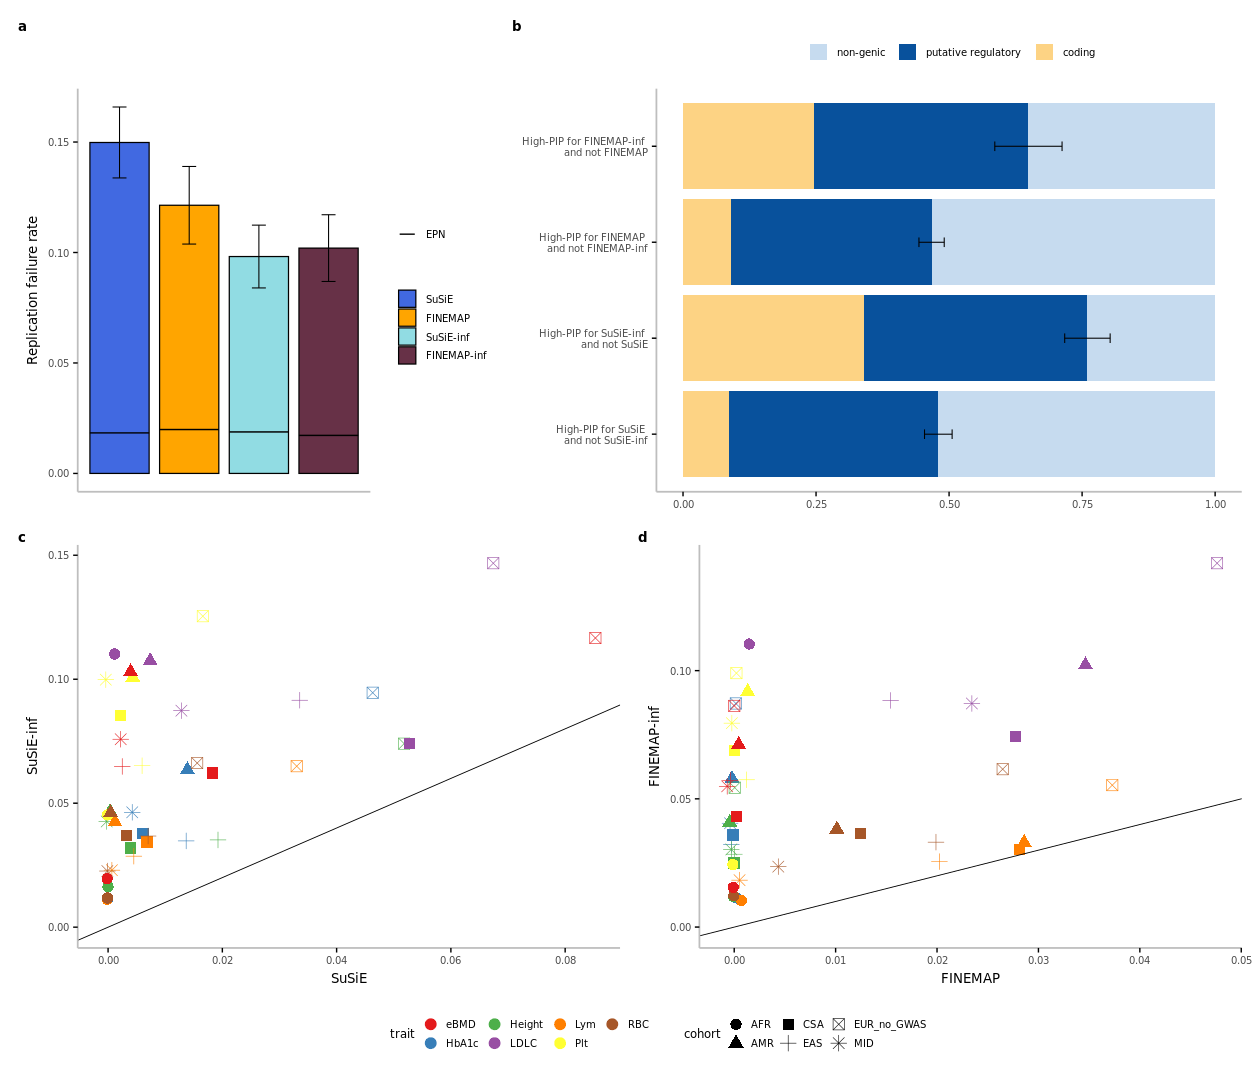

In [156]:
options(repr.plot.width=10.5, repr.plot.height=9)
layout <- "
ABB
CCC
"
fig5 <- pl_rfr + pl_set_diff_enrich + pl_prs + plot_layout(design = layout)+
 plot_annotation(tag_levels = "a") & theme(plot.tag = element_text(face = 'bold', size=8),
                                           legend.justification='center')
fig5

In [157]:
cowplot::save_plot(
  paste0(path_pref, "/Fig5_real_data_improvement.pdf"),
  fig5,
  base_height = 170,
  base_width = 180,
  device = cairo_pdf,
  unit = 'mm'
)